In [ ]:

# cooperativity?

# look in literature for stuff about actual noise of antibody-antigen binding
# We need a name for this thing. Currently it's just called "the simulator"

# Things to do: maybe tune runtime? in noise?

# I suggest we rename excel file to 'Ab_binding_profiles_for_15_classes.xlsx'
# instead of the current file name, '15-class_Ab_binding_profiles.xlsx'
# This way, if we have more than one of these files, they'll group together under 
# alphabetic sorting,as in 'Ab_binding_profiles_for_n_classes.xlsx'

# But also, it might make sense to omit the number entirely from the filename, 
# and just have one file with all the binding profiels in it. We can use python
# to prune the pandas dataframe down to the ones we're using.

# I also suggest we put our excel files and other external data in a subfolder.
# Not sure what to call it. Maybe 'Lookup_tables'?

# Put a pin in it: note that the ellipses in the PCA plots are misleading. 
# The ellipse implies that we are fitting a Gaussian distribution and detecting
# a covariance structure, but actually we are starting with uncorrelated noise and 
# distorting it paraboliically. OK for now but we should be aware of this nuance, 
# and maybe in the future figure out a rigorous way to do this.

# TODO after 9/15/2025: 
# Legend on 3D plot
# move legend so doesn't block data
# implement Lines 9-19 KJM suggestions 

# 9/22/2025:
# fixed the legend placement.
# created a pared down affinities data frame for only the antibodies in use.
# TODO after 9/22/2025:
# implement Lines 9-19 KJM suggestions
# Make noise more realistic. Replicate the empirical noise of 15 classes RGB values from JMC.
# Add legend to 3D PCA plot


# 9/29/2025
# started strip visualizer
# TODO: get strip visualizer to work
# implement Lines 9-19 KJM suggestions
# Make noise more realistic. Replicate the empirical noise of 15 classes RGB values from JMC.
# Add legend to 3D PCA plot
# Finish tidying up and commenting the functions in the FAKE DATA section

# KJM unnecessary idea: Pre-generate a single noise object (in generate_strips) instead of adding noise on the fly








#  10/06/2025
# How to sum pigments
# Figure out how RGB pigment adds (i.e. if you have atwo different colored NPs, how do you sum their colors?)

# Write in concentration of analyte:
# rewrite the equation for spot signal to include the concentration of the analyte
#   -Langmuir binding isotherm (read de Puig et al, Bioconjugate chemistry https://pubs.acs.org/doi/10.1021/acs.bioconjchem.6b00523)
#   -fixed nuber of immobilized Abs
#   -strips are run sequentially to avoid hook effect (antigen is run first, then the IPx)
# then convert concentrations of mixture of immunoprobes into a color

# High Level Assignment:
# 1. Write math for physical model. Equilibrium concentratrions of all species at a spot, assuming strips sequentially run
# 2. Convert physical picture of concentrations into pigment RGB values
# 3. Code

In [49]:
import random
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


    ██╗███╗   ██╗██╗████████╗██╗ █████╗ ██╗     ██╗███████╗███████╗
    ██║████╗  ██║██║╚══██╔══╝██║██╔══██╗██║     ██║╚══███╔╝██╔════╝
    ██║██╔██╗ ██║██║   ██║   ██║███████║██║     ██║  ███╔╝ █████╗  
    ██║██║╚██╗██║██║   ██║   ██║██╔══██║██║     ██║ ███╔╝  ██╔══╝  
    ██║██║ ╚████║██║   ██║   ██║██║  ██║███████╗██║███████╗███████╗
    ╚═╝╚═╝  ╚═══╝╚═╝   ╚═╝   ╚═╝╚═╝  ╚═╝╚══════╝╚═╝╚══════╝╚══════╝

In [ ]:
# =================================
# Make table of nanoparticle colors
# =================================

color_channels = ("R", "G", "B",)
NP_names_all = ("Innova", "Red", "Blue")
NP_colors_all = [
#   Innova   Red     Blue
    [194.27, 178.77, 136.57, ],  # R
    [129.16, 127.22, 155.11, ],  # G
    [161.40, 154.64, 166.40, ],] # B

NP_colors_all = pd.DataFrame(
    NP_colors_all, 
    index = color_channels, 
    columns = NP_names_all,)

# # If you want to load the NP colors from an excel file:
# xls = pd.ExcelFile('NP_colors_RGB.xlsx')
# NP_colors = pd.read_excel(xls, 'NP_colors_RGB_09152025.xlsx', index_col = [0],)
# NP_names = tuple(NP_colors.columns.tolist()) # columns
# color_channels = tuple(NP_colors.index) # rows

In [51]:
# ==========================================
# Load table of idealized binding affinities
# ==========================================

# Currently, antibody binding profiles (mean_affinities) are 5 cols X 15 rows.
# Columns are antibodies, rows are antigens, i.e., 5 antibodies, 15 antigens.

xls = pd.ExcelFile('15-class_Ab_binding_profiles.xlsx')
mean_affins_all = pd.read_excel(xls, 'Ab_profiles_08222025', index_col = [0],)
antibodies_all = tuple(mean_affins_all.columns.tolist()) # columns
antigens_all = tuple(mean_affins_all.index) # rows

In [52]:
# ==========================================================================
# Make tables of antibody pair interferences, initialize with 1.0 as default
# ==========================================================================

# 1.0 = no interference. This is the default value.

# Defines a dictionary mapping each antigen to a table of interference values
# for each pair of antibodies. Basically, if antibody A and antibody B try to
# both bind to this antigen, how much will they interfere with each other. 
# Values are initialized to the default of 1.0, meaning no interference.

interferences_all = {
    antigen: pd.DataFrame(
        data = 1.0, # default
        index = antibodies_all,
        columns = antibodies_all)
    for antigen in antigens_all}

# ========================================
# Declare specific pairs that do interfere
# ========================================

# Example: declare a symmetric interference of 0.5 for antibodies A and B.
# The strings 'some antigen', 'antibody A', and 'antibody B' need to correspond
# to the actual names of your antigen and your two antibodies, defined earlier.
# interferences['some antigen'].at['antibody A', 'antibody B'] = 0.5
# interferences['some antigen'].at['antibody B', 'antibody A'] = 0.5

# Currently, none are set to interfere

In [53]:
# ==============================
# Declare which antigens to test
# ==============================

# Antigens are the target analytes that bind to the antibodies. 
# We might be interested in only a subset of the antigens we have
# defined in the Excel file, so here we can specify which ones we
# want to include in our simulation. If we want to use all of them,
# we simply copy() antigens_all, otherwise we list the names.

antigens = tuple(list(antigens_all).copy())
# antigens = ("name 1", "name 2", etc)

# =======================================================
# Declare which antibodies to use as test lines, in order
# =======================================================

# "Test line" antibodies are the spots in the paper strip.
# If we want to use all of them, we copy() antibodies_all,
# otherwise we list the names of the antibodies.

test_lines = tuple(list(antibodies_all).copy())
# test_lines = ("name 1", "name 2", etc)

# ==================================================================
# Declare which immunoprobe antibodies pair with which nanoparticles
# ==================================================================

# "Immunoprobe" antibodies are incubated in the test solution.
# Each immunoprobe is conjugated with a dye nanoparticle (NP).
# Define these pairings below: "immunoprobe": "NP"

immunoprobe_NPs = {
    "Dengue SinoBio": "Red", 
    "Dengue CTK": "Blue", 
    "Powassan": "Innova"}

# ================================================================
# Variables that derive from the ones above, don't mess with these
# ================================================================

# It will be convenient, for readability later in the code, to define
# two variables here that list the immunoprobes and nanoparticles we
# are using in our experiment. We get the lists by extracting the
# keys and values from the dictionary of pairings defined above.
# Don't mess with these definitions. If you want to change the 
# immunoprobes or nanoparticles, change the dictionary above.
immunoprobes = tuple(immunoprobe_NPs.keys())
NP_names = tuple(immunoprobe_NPs.values())

# Our list of all the antibodies we are using in our experiment, i.e.,
# any antibody that we use as either a test line and/or an immunoprobe.
# The "|" symbol means "union", or in plain english, "and/or".
# Because we us a set-based construction, there are no duplicates.
# Don't mess with this definition. If you want to change the list of 
# antibodies, edit the test lines or the immunoprobes defined earlier.
antibodies = tuple(set(test_lines) | set(immunoprobes))

# Create a smaller affinities table with entries only for the antibodies
# and antigens we are actually using, removing extraneous entries.
# Note that axis 0 is rows, and axis 1 is columns.
mean_affins = mean_affins_all.copy() 
for antibody in antibodies_all:
    if antibody not in antibodies:
        mean_affins = mean_affins.drop(antibody, axis = 1)
for antigen in antigens_all:
    if antigen not in antigens:
        mean_affins = mean_affins.drop(antigen, axis = 0)

# =================================
# Sanity checks, checking for typos
# =================================

for antigen in antigens:
    assert antigen in antigens_all
for test_line in test_lines:
    assert test_line in antibodies_all
for probe in immunoprobes:
    assert probe in antibodies_all
    NP_name = immunoprobe_NPs[probe]
    assert NP_name in NP_names_all

In [54]:
# ============================================================
# Define the level of experimental noise and error to simulate
# ============================================================

# Our math gives exact answers, but real lab experiments have noise 
# and error. To simulate this, we want to add some randomness when we 
# calculate our virtual test results for a given antigen. 
# 
# Specifically, we'll add normally-distributed noise to the affinities
# when we calculate values for each strip, for each spot in the strip, 
# and for each antibody sandwich in the spot. Below, we define a 
# strip-level variance for each antigen, and we scale the spot- and 
# sandwich-level noise relative to it.

# Define target variance for each antigen. Currently arbitrary
variances = {antigen: 0.0005 for antigen in antigens}

# TODO write comment
noise_scaling_spot = 0.5
noise_scaling_sandwich = 0.2

# =============================================================
# Don't mess with this part, numpy requires covariance matrices
# =============================================================

# For each antigen, set covariance matrix to an identity matrix scaled 
# by the desired target variance for that antigen. Identity matrix is 
# nxn, where n is the number of unique antibodies in our test.
I = np.identity(len(antibodies))
cov_matrices = {
    antigen: I * variances[antigen] 
    for antigen in variances}

# =================================
# Sanity checks, checking for typos
# =================================

for antigen in variances:
    assert antigen in antigens

    ███████╗ █████╗ ██╗  ██╗███████╗    ██████╗  █████╗ ████████╗ █████╗ 
    ██╔════╝██╔══██╗██║ ██╔╝██╔════╝    ██╔══██╗██╔══██╗╚══██╔══╝██╔══██╗
    █████╗  ███████║█████╔╝ █████╗      ██║  ██║███████║   ██║   ███████║
    ██╔══╝  ██╔══██║██╔═██╗ ██╔══╝      ██║  ██║██╔══██║   ██║   ██╔══██║
    ██║     ██║  ██║██║  ██╗███████╗    ██████╔╝██║  ██║   ██║   ██║  ██║
    ╚═╝     ╚═╝  ╚═╝╚═╝  ╚═╝╚══════╝    ╚═════╝ ╚═╝  ╚═╝   ╚═╝   ╚═╝  ╚═╝

In [55]:
# ==========================
# Math to generate fake data
# ==========================

def add_noise_to_affins(
        antigen: str, 
        affins: pd.DataFrame,
        scaling: float = 1.0,
        ) -> pd.DataFrame:
    noisy_affins = affins.copy()
    deviations = np.random.multivariate_normal(
        mean = np.zeros(cov_matrices[antigen].shape[0]), 
        cov = cov_matrices[antigen])
    i = 0
    for antibody in antibodies:
        noisy_affins.loc[antigen, antibody] += (deviations[i] * scaling)
        i += 1
    return noisy_affins

def sandwich_color(
        antigen: str, 
        test_line: str, 
        immunoprobe: str, 
        affins: pd.DataFrame,
        add_noise: bool,
        ) -> pd.Series:
    '''Generate color channel data for a single sandwich'''
    if add_noise: affins = add_noise_to_affins(antigen, affins, noise_scaling_sandwich)
    NP_color = NP_colors_all[immunoprobe_NPs[immunoprobe]].copy()
    immunoprobe_affinity = affins.at[antigen, immunoprobe]
    test_line_affinity = affins.at[antigen, test_line]
    sandwich_affinity = test_line_affinity * immunoprobe_affinity
    interference = interferences_all[antigen].at[test_line, immunoprobe]
    return NP_color * sandwich_affinity * interference

def spot_color(
        antigen: str, 
        test_line: str, 
        affins: pd.DataFrame, 
        add_noise: bool,
        ) -> pd.Series:
    '''
    Generate color channel values for a single spot on a test strip,
    by summing contributions from all the different immunoprobes that
    bind (form sandwiches) at that spot. (A sandwich consists of a
    test line antibody and an immunoprobe both bound to an angiten.)

    Returns the result as a Pandas "series" object, which is basically
    one row of a Pandas dataframe. These can be concatenated to form
    the rows of a multi-row dataframe representing the entire strip.
    '''
    color = pd.Series([255.0]*len(color_channels), index = color_channels, dtype = float,)
    if add_noise: affins = add_noise_to_affins(antigen, affins, noise_scaling_spot)
    for probe in immunoprobes: 
        color -= sandwich_color(antigen, test_line, probe, affins, add_noise)
    return color

def strip_colors(antigen: str, add_noise: bool) -> pd.DataFrame:
    '''
    Generates a complete test strip for the given antigen, in the 
    form of a Pandas dataframe where the rows are the test lines and
    the columns are the color channels, e.g., RGB.
    '''
    affins = mean_affins
    if add_noise: affins = add_noise_to_affins(antigen, affins)
    result = pd.DataFrame(index = test_lines, columns = color_channels, dtype=float,)
    for test_line in test_lines: 
        result.loc[test_line] = spot_color(antigen, test_line, affins, add_noise)
    return result

def generate_strips(strips_per_antigen=1,add_noise = False) -> tuple[np.ndarray, list]:
    '''
    Generate N strips for each antigen in use. Currently (2025/01/04), returns
    the strips as a list of dataframes. Each dataframe is one strip. The rows
    are spots along the strip, and the columns are color channel values, e.g.,
    R, G, and B values, or whatever color channels you're using.
    '''

    all_data = []
    all_labels = []

    for antigen in antigens:
        for _ in range(strips_per_antigen):
            strip = strip_colors(antigen, add_noise=add_noise)
            all_data.append(strip)
            all_labels.append(antigen)
 
    # Convert each strip to an RGB vector
    X = []
    for strip in all_data:
        flat=np.ravel(strip.to_numpy())
        X.append(flat)

    # Convert to 2D numpy array suitable for PCA
    X = np.array(X)

    return (np.array(X), all_data, all_labels)

# 'strips' is the raw colorimetric data for all generated strips (all antigens in use)
# 'strip_labels' corresponds to strips, provides the antigen name for each entry in strips
strips_list, unflattened_strips, strip_labels = generate_strips(strips_per_antigen=100, add_noise=True)

     █████╗ ███╗   ██╗ █████╗ ██╗  ██╗   ██╗███████╗██╗███████╗
    ██╔══██╗████╗  ██║██╔══██╗██║  ╚██╗ ██╔╝██╔════╝██║██╔════╝
    ███████║██╔██╗ ██║███████║██║   ╚████╔╝ ███████╗██║███████╗
    ██╔══██║██║╚██╗██║██╔══██║██║    ╚██╔╝  ╚════██║██║╚════██║
    ██║  ██║██║ ╚████║██║  ██║███████╗██║   ███████║██║███████║
    ╚═╝  ╚═╝╚═╝  ╚═══╝╚═╝  ╚═╝╚══════╝╚═╝   ╚══════╝╚═╝╚══════╝

In [56]:
# =================
# 3-dimensional PCA
# =================

# Perform PCA 
pca_3D = PCA(n_components=3)
strips_pca_3D = pca_3D.fit_transform(strips_list)

# cluster_points_3D: break up all_data into subsets by antigen
cluster_points_3D = []
for antigen in antigens:
    mask = [label == antigen for label in strip_labels]
    cluster_points_3D.append(strips_pca_3D[mask])

# cluster_means_3D: the mean of the points in each cluster
cluster_means_3D = []
for cluster in cluster_points_3D:
    mean_of_points = np.mean(cluster, axis=0)
    cluster_means_3D.append(mean_of_points)

# cluster_covs_3D: the covariance matrices of the points in each cluster
cluster_covs_3D = []
for cluster in cluster_points_3D:
    cov_of_points = np.cov(cluster.T)
    cluster_covs_3D.append(cov_of_points)

# cluster_colors_3D: the color that each color will be plotted in
cluster_colors_3D = []
for _ in range(len(cluster_points_3D)):
    plot_color = str('#%02X%02X%02X' % (
        random.randint(0,255),
        random.randint(0,255),
        random.randint(0,255)))    
    cluster_colors_3D.append(plot_color)


In [57]:
# =================
# 2-dimensional PCA
# =================

# Perform PCA
pca_2D = PCA(n_components=2)
strips_pca_2D = pca_2D.fit_transform(strips_list)

# cluster_points_2D: break up all_data into subsets by antigen
cluster_points_2D = []
for antigen in antigens:
    mask = [label == antigen for label in strip_labels]
    cluster_points_2D.append(strips_pca_2D[mask])

# cluster_means_2D: the mean of the points in each cluster
cluster_means_2D = []
for cluster in cluster_points_2D:
    mean_of_points = np.mean(cluster, axis=0)
    cluster_means_2D.append(mean_of_points)

# cluster_covs_2D: the covariance matrices of the points in each cluster
cluster_covs_2D = []
for cluster in cluster_points_2D:
    cov_of_points = np.cov(cluster.T)
    cluster_covs_2D.append(cov_of_points)

# using same colors as 3D
cluster_colors_2D=cluster_colors_3D.copy()

    ██████╗ ██╗      ██████╗ ████████╗    ██████╗  █████╗ ████████╗ █████╗ 
    ██╔══██╗██║     ██╔═══██╗╚══██╔══╝    ██╔══██╗██╔══██╗╚══██╔══╝██╔══██╗
    ██████╔╝██║     ██║   ██║   ██║       ██║  ██║███████║   ██║   ███████║
    ██╔═══╝ ██║     ██║   ██║   ██║       ██║  ██║██╔══██║   ██║   ██╔══██║
    ██║     ███████╗╚██████╔╝   ██║       ██████╔╝██║  ██║   ██║   ██║  ██║
    ╚═╝     ╚══════╝ ╚═════╝    ╚═╝       ╚═════╝ ╚═╝  ╚═╝   ╚═╝   ╚═╝  ╚═╝

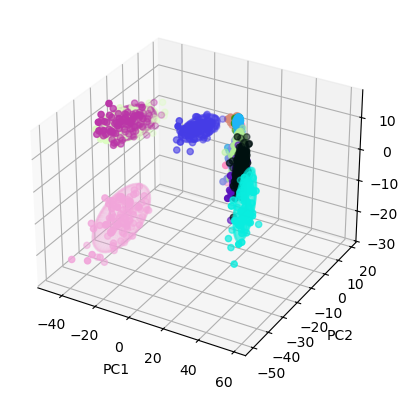

In [58]:
# Ellipsoid code from https://github.com/CircusMonkey/covariance-ellipsoid/blob/master/ellipsoid.py 
# August 2025

def get_cov_ellipsoid(cov, mu=np.zeros((3)), nstd=3):
    """
    Return the 3d points representing the covariance matrix
    cov centred at mu and scaled by the factor nstd.

    Plot on your favourite 3d axis. 
    Example 1:  ax.plot_wireframe(X,Y,Z,alpha=0.1)
    Example 2:  ax.plot_surface(X,Y,Z,alpha=0.1)
    """
    assert cov.shape==(3,3)

    # Find and sort eigenvalues to correspond to the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.sum(cov,axis=0).argsort()
    eigvals_temp = eigvals[idx]
    idx = eigvals_temp.argsort()
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    # Set of all spherical angles to draw our ellipsoid
    n_points = 100
    theta = np.linspace(0, 2*np.pi, n_points)
    phi = np.linspace(0, np.pi, n_points)

    # Width, height and depth of ellipsoid
    rx, ry, rz = nstd * np.sqrt(eigvals)

    # Get the xyz points for plotting
    # Cartesian coordinates that correspond to the spherical angles:
    X = rx * np.outer(np.cos(theta), np.sin(phi))
    Y = ry * np.outer(np.sin(theta), np.sin(phi))
    Z = rz * np.outer(np.ones_like(theta), np.cos(phi))

    # Rotate ellipsoid for off axis alignment
    old_shape = X.shape
    # Flatten to vectorise rotation
    X,Y,Z = X.flatten(), Y.flatten(), Z.flatten()
    X,Y,Z = np.matmul(eigvecs, np.array([X,Y,Z]))
    X,Y,Z = X.reshape(old_shape), Y.reshape(old_shape), Z.reshape(old_shape)
   
    # Add in offsets for the mean
    X = X + mu[0]
    Y = Y + mu[1]
    Z = Z + mu[2]
    
    return X,Y,Z


 # Setup the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('PC1')
plt.ylabel('PC2')

# plot data points and ellipses

nstd = 2 # number of standard deviations of ellipsoid; determines the ellipsoid volume

for antigen in antigens:
    i = antigens.index(antigen)
    points = cluster_points_3D[i]
    mean = cluster_means_3D[i]
    cov = cluster_covs_3D[i]
    plot_color = cluster_colors_3D[i] 
    X1,Y1,Z1 = get_cov_ellipsoid(cov, mean, nstd)
    ax.plot_wireframe(X1,Y1,Z1, color = plot_color, alpha=0.1)
    ax.scatter(points[:,0],points[:,1],points[:,2],c =plot_color)

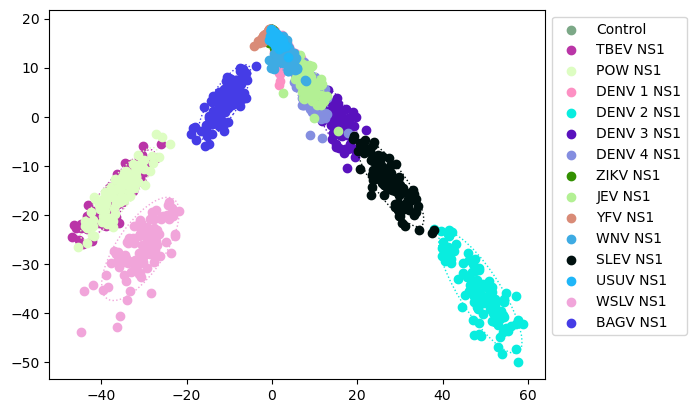

In [59]:
# plot the 2D PCA, legend

# from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


fig = plt.figure()
ax = fig.add_subplot(111,)

for antigen in antigens:
    i = antigens.index(antigen)
    cluster = cluster_points_2D[i]
    cluster_x = cluster[:,0]
    cluster_y = cluster[:,1]
    color=cluster_colors_2D[i]
    confidence_ellipse(cluster_x, cluster_y, ax, 2,  edgecolor=color, linestyle=':')
    ax.scatter(cluster_x, cluster_y, label = antigen, c=color)
ax.legend(bbox_to_anchor=(1, 1),)
ax.autoscale()
plt.show()





    ██████╗ ██████╗ ██╗███╗   ██╗████████╗     ██████╗ ██████╗ ██╗      ██████╗ ██████╗ ███████╗
    ██╔══██╗██╔══██╗██║████╗  ██║╚══██╔══╝    ██╔════╝██╔═══██╗██║     ██╔═══██╗██╔══██╗██╔════╝
    ██████╔╝██████╔╝██║██╔██╗ ██║   ██║       ██║     ██║   ██║██║     ██║   ██║██████╔╝███████╗
    ██╔═══╝ ██╔══██╗██║██║╚██╗██║   ██║       ██║     ██║   ██║██║     ██║   ██║██╔══██╗╚════██║
    ██║     ██║  ██║██║██║ ╚████║   ██║       ╚██████╗╚██████╔╝███████╗╚██████╔╝██║  ██║███████║
    ╚═╝     ╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝   ╚═╝        ╚═════╝ ╚═════╝ ╚══════╝ ╚═════╝ ╚═╝  ╚═╝╚══════╝

            R_Powassan  G_Powassan  B_Powassan  R_Dengue CTK  G_Dengue CTK  \
Control     255.000000       255.0  255.000000    255.000000         255.0   
TBEV NS1    204.748770       255.0  254.703676    254.701469         255.0   
POW NS1     206.486686       255.0  254.817341    254.816271         255.0   
DENV 1 NS1  255.000000       255.0  255.000000    252.566667         255.0   
DENV 2 NS1  255.000000       255.0  255.000000    221.858182         255.0   
DENV 3 NS1  254.985398       255.0  254.987748    242.327591         255.0   
DENV 4 NS1  254.126471       255.0  254.241000    246.651000         255.0   
ZIKV NS1    254.995027       255.0  254.997357    254.664850         255.0   
JEV NS1     255.000000       255.0  255.000000    247.891680         255.0   
YFV NS1     253.781341       255.0  255.000000    255.000000         255.0   
WNV NS1     254.967056       255.0  254.990718    252.593292         255.0   
SLEV NS1    254.804933       255.0  254.696388    235.933839    

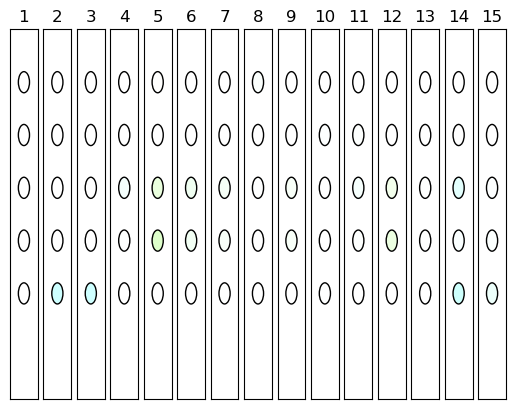

In [60]:
# =================================================
# Prints the RGB values of all strips without noise
# =================================================

r = generate_strips(strips_per_antigen = 1, add_noise = False)
(idealized_strips, idealized_strips_unflattened, idealized_strip_labels) = r
# convert 2D numpy array (PCA-suitable) to list of 1D numpy arrays:
idealized_strips = list(idealized_strips)

column_names = []
for test_line in test_lines:
    column_names.append(f"R_{test_line}")
    column_names.append(f"G_{test_line}")
    column_names.append(f"B_{test_line}")

idealized_strips = pd.DataFrame(
    idealized_strips, 
    index = antigens, 
    columns = column_names,)

idealized_strips.to_csv('idealized_strip_colors_RGB.csv', index=True)
print(idealized_strips)

# ===============================================
# Generate images of simulated strips with colors
# ===============================================

# TODO: iteratively make all plots look good like 1st one
# read the RGB data file

def RGB_to_hex(r,g,b): 
    return str('#%02X%02X%02X' % (r,g,b))  

def visualize_RGB_strips(strips_list):
    '''
    Visualize strip data, i.e., generate images of the strips.

    Pass data as an unflattened list of strips, where each strip is a dataframe,
    with rows as test lines and columns as RGB color channels R, G, and B. 
    '''
    fig, axes = plt.subplots(1, len(strips_list))
    number_of_spots = len(test_lines)
    circle_size = 0.2
    j = 1
    ax_map = dict(zip(antigens, axes))
    strip_map = dict(zip(antigens, strips_list))
    for antigen in antigens:
        ax = ax_map[antigen]
        strip = strip_map[antigen]
        i = 0
        for test_line in test_lines:
            row = strip.loc[test_line]
            r = int(row["R"])
            g = int(row["G"])
            b = int(row["B"])
            color = RGB_to_hex(r,g,b)
            r = row["R"]/255
            g = row["G"]/255
            b = row["B"]/255
            x = 0; y = i+1
            c = Circle((x,y), circle_size, facecolor=(r,g,b), edgecolor='black', linewidth = 1,)
            ax.add_artist(c)
            ax.set_xlim([-.5,.5])
            ax.set_ylim([-1,number_of_spots+1])
            ax.set_title( j )
            ax.xaxis.set_major_locator(ticker.NullLocator())
            ax.yaxis.set_major_locator(ticker.NullLocator())
            i+=1
        j+=1
    # for ax in axes: 
    #     for i in range(number_of_spot):
    #         x = 0; y = i+1
    #         c = Circle((x,y), circle_size, facecolor=(0.4, 0.2, 0.4), edgecolor='black', linewidth = 1,)
    #         ax.add_artist(c)
    #         ax.set_xlim([-.5,.5])
    #         ax.set_ylim([-1,number_of_spots+1])
    #         ax.set_title( j )
    #         ax.xaxis.set_major_locator(ticker.NullLocator())
    #         ax.yaxis.set_major_locator(ticker.NullLocator())
    #     j+=1

    plt.savefig("strips.png")    
    plt.show()

visualize_RGB_strips(idealized_strips_unflattened)

    ██████╗ ██╗      ██████╗ ████████╗    ██╗  ██╗ ██████╗ █████╗ 
    ██╔══██╗██║     ██╔═══██╗╚══██╔══╝    ██║  ██║██╔════╝██╔══██╗
    ██████╔╝██║     ██║   ██║   ██║       ███████║██║     ███████║
    ██╔═══╝ ██║     ██║   ██║   ██║       ██╔══██║██║     ██╔══██║
    ██║     ███████╗╚██████╔╝   ██║       ██║  ██║╚██████╗██║  ██║
    ╚═╝     ╚══════╝ ╚═════╝    ╚═╝       ╚═╝  ╚═╝ ╚═════╝╚═╝  ╚═╝

In [61]:
################################################################################
# New HCA code block: from GEMINI
################################################################################

# Perform hierarchical clustering on the same 6D data (X)
# We use the 'ward' method, which is good for minimizing the variance
# within each cluster, and 'euclidean' metric is the default and a good choice.
Z = sch.linkage(idealized_strips_unflattened, method = 'ward')

# Create a figure for the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Cluster Analysis Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")

# Create the dendrogram
sch.dendrogram(
    Z,
    labels = idealized_strip_labels,
    leaf_rotation=90.,  # Rotate the leaf labels for better readability
    leaf_font_size=10.,
)

# You can add a horizontal line to "cut" the dendrogram and
# visually determine the clusters. A value of 't' for the fcluster function.
# plt.axhline(y=10, c='k', linestyle='--') # Example cut-off line

plt.tight_layout()
plt.show()

# To get the cluster assignments from the dendrogram, you can 'cut' it
# at a specific distance threshold. For example, a threshold of 10.
# You can adjust this value based on what you see in the dendrogram.
# from scipy.cluster.hierarchy import fcluster
# cluster_labels_hca = fcluster(Z, t=10, criterion='distance')
# print("HCA Cluster Labels:", cluster_labels_hca)

# You could also get a specific number of clusters.
# cluster_labels_hca_3 = fcluster(Z, t=3, criterion='maxclust')
# print("HCA Cluster Labels (3 clusters):", cluster_labels_hca_3)

ValueError: `y` must be 1 or 2 dimensional.